In [1]:
# !pip install statsmodels

In [46]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


# **SVR (Support Vector Regression) based model for the prediction of Concrete Compressive Strength**

In [48]:
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.model_selection import cross_val_score, KFold
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import seaborn as sns; sns.set()
from sklearn.feature_selection import mutual_info_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor

### **Data preparation for SVRegression**

In [49]:
file_path = "Concrete_Strength_Data.csv"
concrete_data = pd.read_csv(file_path)

y_initial = concrete_data['Strength']
y_initial = np.array(y_initial)
concrete_data = concrete_data.drop(columns=['Strength'])

### **Plot for quantifying Correlation between different parameters**

Text(0.5, 1.0, 'Correlation Heatmap')

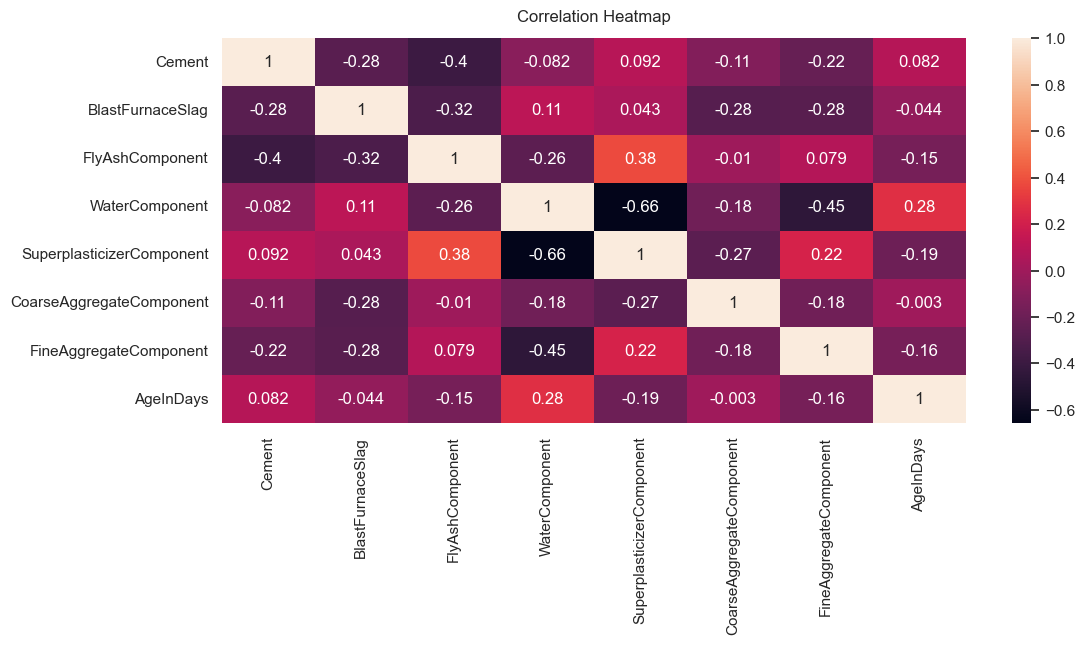

In [50]:
plt.figure(figsize=(12, 5))
sns.heatmap(concrete_data.corr(), annot=True)
plt.title('Correlation Heatmap', fontdict={'fontsize' : 12}, pad=12)

* From the heatmap it is evident that there exist a significant correlation between predictors (independent variables). So, to formulate robust regression only one of the highly correlated variables is included or combined together to form a **composite predictors** which in turn reduces the overall **multicollinearity** in the model.

### **Mutual Information Scores**

In [51]:
x = concrete_data.copy()
y = y_initial
x_mi = x.copy()
for colname in x_mi.select_dtypes('object'):
    x_mi[colname], _ = x_mi[colname].factorize()

discrete_features = x_mi.dtypes == object
discrete_features[x_mi.columns] = False

def generate_mi_scores(x_mi, y, discrete_features):
    mi_scores = mutual_info_regression(x_mi, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name='MI Scores', index=x_mi.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = generate_mi_scores(x_mi, y, discrete_features)
mi_scores

AgeInDays                    0.356412
WaterComponent               0.351119
Cement                       0.307410
CoarseAggregateComponent     0.255701
FineAggregateComponent       0.214774
SuperplasticizerComponent    0.209089
BlastFurnaceSlag             0.180880
FlyAshComponent              0.122488
Name: MI Scores, dtype: float64

### **Mutual Information Score Visualization: Plot**

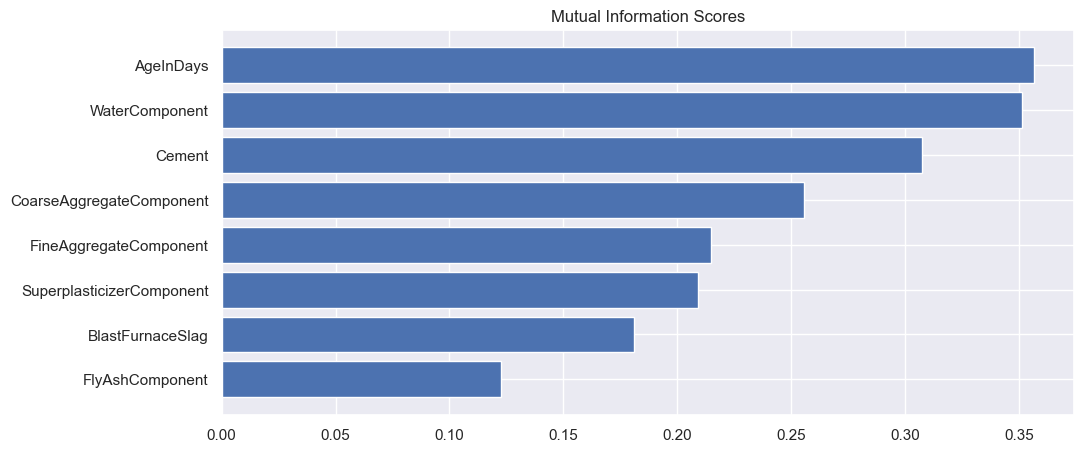

In [52]:
def mi_scores_plot(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title('Mutual Information Scores')
    
plt.figure(dpi=100, figsize=(11, 5))
mi_scores_plot(mi_scores)

* The mutual information scores are significantly high for:
  - **Cement**
  - **Water**
  - **Age in Days**
* Based on mutual information score the **water component** and **cement content** can be combined to form a composite predictor (variable): **Water/Cement Ratio**

### **Ordinary Least Square (OLS) Regression**

In [53]:
#generate OLS regression results for all features
import statsmodels.api as sm

x_sm = sm.add_constant(x)
model = sm.OLS(y,x_sm)
print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     204.3
Date:                Sun, 22 Dec 2024   Prob (F-statistic):          6.29e-206
Time:                        00:03:00   Log-Likelihood:                -3869.0
No. Observations:                1030   AIC:                             7756.
Df Residuals:                    1021   BIC:                             7800.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

* $P > |t|$ is the probability of null hypothesis $H_0$ being true.
* For variables with $P < 0.05$ null hypothesis can be rejected.
* So, based on $P > |t|$ values of the variables **Coarse Aggregate and Fine Aggregate component** has the highest probability of $H_0$ being true.

### **Variation Inflation Factor (VIF)**

In [54]:
vif_data = pd.DataFrame()
vif_data['Features'] = x.columns
vif_data['VIF'] = [variance_inflation_factor(x.values, i)
                  for i in range(len(x.columns))]
print(vif_data)

                    Features        VIF
0                     Cement  15.456717
1           BlastFurnaceSlag   3.329127
2            FlyAshComponent   4.147833
3             WaterComponent  82.157569
4  SuperplasticizerComponent   5.471094
5   CoarseAggregateComponent  84.955779
6     FineAggregateComponent  72.790995
7                  AgeInDays   1.699459


* **VIF = 1:** No correlation amond the given predictors and the others, implying no evidence of multicollinearity.
* **1 < VIF < 5** Moderate correlation.
* **VIF >= 5** Significant multicollinearity, considered as a threshold.
* **VIF >= 10** problematic multicollinearity. Coefficient unstability, standard errors are inflated and inference about the effect of predictors may be unreliable.
* **Strategies to handle the high VIF score predictors (Independent Variables):**
    * Dropped or substrituted the redundant predictors (independent variables).
    * Combined predictors with high VIF scores i.e. the ones with high multicolinearity.

In [55]:
x_initial = np.zeros_like(concrete_data)
x_val_list = []
for i in range(0, len(concrete_data), 1):
  x_val = concrete_data.iloc[i]
  x_val_list.append(x_val)
x_val_array = np.array(x_val_list)
x_initial = x_val_array

# concrete_data['W/C Ratio'] = concrete_data['WaterComponent'] / concrete_data['Cement']
# concrete_data['Fine/Coarse Ratio'] = concrete_data['FineAggregateComponent'] / concrete_data['CoarseAggregateComponent']
# concrete_data = concrete_data.drop(columns=['WaterComponent', 'Cement'])
# concrete_data = concrete_data.drop(columns=['FineAggregateComponent', 'CoarseAggregateComponent'])

concrete_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Cement                     1030 non-null   float64
 1   BlastFurnaceSlag           1030 non-null   float64
 2   FlyAshComponent            1030 non-null   float64
 3   WaterComponent             1030 non-null   float64
 4   SuperplasticizerComponent  1030 non-null   float64
 5   CoarseAggregateComponent   1030 non-null   float64
 6   FineAggregateComponent     1030 non-null   float64
 7   AgeInDays                  1030 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 64.5 KB


#### **Note:** 
* Significant reduction observed in the **VIF scores** post addition of composite predictors in the data set (*can be seen in the data frame below*).
* Composite predictors are:
  - **Water/Cement Ratio**
  - **Fine/Coarse Aggregate Component**

In [56]:
x = concrete_data.copy()
vif_data = pd.DataFrame()
vif_data['Features'] = x.columns
vif_data['VIF'] = [variance_inflation_factor(x.values, i)
                  for i in range(len(x.columns))]
print(vif_data)

                    Features        VIF
0                     Cement  15.456717
1           BlastFurnaceSlag   3.329127
2            FlyAshComponent   4.147833
3             WaterComponent  82.157569
4  SuperplasticizerComponent   5.471094
5   CoarseAggregateComponent  84.955779
6     FineAggregateComponent  72.790995
7                  AgeInDays   1.699459


### **SVRegression training data preparation**

In [73]:
x_train, x_test, y_train, y_test = train_test_split(x_initial,
                                                    y_initial,
                                                    test_size=.2,
                                                    random_state=42,
                                                   shuffle=True)

scaler = StandardScaler()
# x_train_scaled = scaler.fit_transform(x_train)
# x_test_scaled = scaler.transform(x_test)

x_train_scaled = x_train
x_test_scaled = x_test

### **SVR Hyperparameter Tuning Employing Grid Search approach**

In [74]:
param_grid = {
    'kernel' : ['rbf'],
    'C' : [0.1, 1, 10, 100, 1000],
    'epsilon' : [0.01, 0.1, 1],
    'gamma' : ['scale', 'auto']
}

grid_search = GridSearchCV(
    estimator = SVR(),
    param_grid = param_grid,
    scoring = 'r2',
    cv = 5,
    n_jobs = -1,
    verbose = 2
)

grid_search.fit(x_train_scaled, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'epsilon': [0.01, 0.1, 1], 'gamma': ['scale', 'auto'],
                         'kernel': ['rbf']},
             scoring='r2', verbose=2)

**Tuned Parameters for the SVR model are -**
* **C** = 100
* **epsilon** = 1
* **gamma** = 0.1
* **kernel** = radial basis function (rbf)
* The parameter tuning ensures that the model is neither **overfitting** nor **underfitting** the data. 

In [75]:
best_svr_model = grid_search.best_estimator_
# best_svr_model = SVR(C = 100,
#                      epsilon = 1,
#                      gamma = 'scale',
#                      kernel = 'rbf')

best_svr_model.fit(x_test_scaled, y_test)
y_pred = best_svr_model.predict(x_test_scaled)

print('SV Regression Metric:')
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))
print('R-squared: {}'.format(r2_score(y_test, y_pred)))

SV Regression Metric:
RMSE: 6.9543595335989
R-squared: 0.8123110081636775


### **Residual Plot**

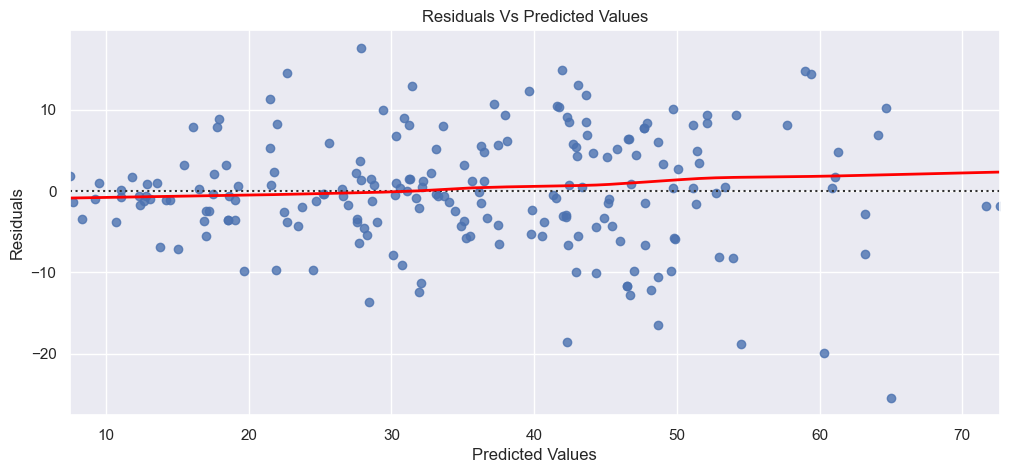

In [76]:
plt.figure(figsize = (12, 5))
sns.residplot(x = y_pred, 
              y = y_test, 
              lowess = True, 
              line_kws = {'color': 'red', 'lw': 2})

plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals Vs Predicted Values')
plt.show()

* The random residual scatter in the plot above confirms the models ability to capture all systematic information.
* Upon averaging the residuals should sum to **0**, indicating no overfit or underfit to the data (*as shown by a non-parameteric line in the above residual plot*)
* Considering the modeling goal to be prediction, the non-constant variance accross all levels of the predictors (independent variables) does not significantly impacts the model's prediction preformance.

### **Prediction Vs Observed Values Plot**

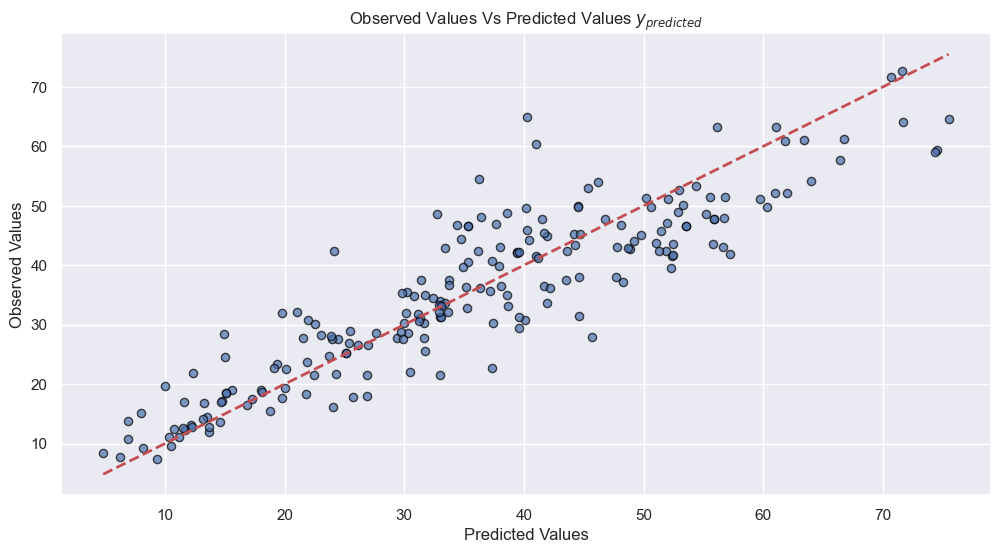

In [77]:
plt.figure(figsize = (12, 6))
plt.scatter(y_test, 
            y_pred, 
            edgecolors = (0, 0, 0), 
            alpha = 0.7,
            s = 35)

plt.plot([y_test.min(), y_test.max()], 
         [y_test.min(), y_test.max()], 
         'r--', 
         lw = 2)

plt.xlabel('Predicted Values')
plt.ylabel('Observed Values')
plt.title('Observed Values Vs Predicted Values $y_{predicted}$')
plt.show()